In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import tensorflow as tf

from IPython.display import Audio
from IPython.display import display

print(tf.__version__)

2.8.0


In [2]:
# Establezca el valor semilla para la reproducibilidad del experimento.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Importar el conjunto de datos de mini comandos de voz

Para ahorrar tiempo con la carga de datos, trabajará con una versión más pequeña del conjunto de datos de comandos de voz. El conjunto de [datos original](https://www.tensorflow.org/datasets/catalog/speech_commands) consta de más de 105 000 archivos de audio en [formato de archivo de audio WAV (Waveform)](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) de personas que dicen 35 palabras diferentes. Estos datos fueron recopilados por Google y publicados bajo una licencia CC BY.

Descargue y extraiga el archivo `mini_speech_commands.zip` que contiene los conjuntos de datos de comandos de voz más pequeños con [`tf.keras.utils.get_file`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) :

In [3]:
DATASET_PATH = 'data/mini_speech_commands' # Ruta del dataset

data_dir = pathlib.Path(DATASET_PATH) # Creamos un objeto de la clase Path con la ruta del dataset
if not data_dir.exists(): 
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        'https://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
        extract=True,
        cache_dir='.',
        cache_subdir='data') # Descargamos el dataset

Los clips de audio del conjunto de datos se almacenan en ocho carpetas correspondientes a cada comando de voz: `no` , `yes` , `down` , `go` , `left` , `up` , `right` y `stop` :

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir))) # Obtenemos los comandos
commands = commands[commands != 'README.md'] # Eliminamos el archivo README.md
print('Commands:', commands) # Mostramos los comandos

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Extraiga los clips de audio en una lista llamada `filenames` de archivo y mezcle:

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*') # Lista de archivos de audio
filenames = tf.random.shuffle(filenames) # Barajamos los archivos de audio
num_samples = len(filenames) # Numero de archivos de audio
print('Num samples:', num_samples) # Mostramos el numero de archivos de audio
print('Number of samples per label:', len(tf.io.gfile.listdir(str(data_dir) + '/' + commands[0]))) # Mostramos el numero de archivos de audio por comando
print('Example file tensor:', filenames[0]) # Mostramos un ejemplo de archivo de audio

Num samples: 8000
Number of samples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\no\\b06c19b0_nohash_0.wav', shape=(), dtype=string)


Divida los nombres de `filenames` en conjuntos de entrenamiento, validación y prueba utilizando una proporción de 80:10:10, respectivamente:

In [6]:
train_files = filenames[:6400] # Archivos de audio de entrenamiento
val_files = filenames[6400: 6400 + 800] # Archivos de audio de validacion
test_files = filenames[-800:] # Archivos de audio de test

print('Train files:', len(train_files)) # Mostramos el numero de archivos de audio de entrenamiento
print('Val files:', len(val_files)) # Mostramos el numero de archivos de audio de validacion
print('Test files:', len(test_files)) # Mostramos el numero de archivos de audio de test

Train files: 6400
Val files: 800
Test files: 800


### Leer los archivos de audio y sus etiquetas.

En esta sección, preprocesará el conjunto de datos, creando tensores decodificados para las formas de onda y las etiquetas correspondientes. Tenga en cuenta que:

- Cada archivo WAV contiene datos de series temporales con un número determinado de muestras por segundo.
- Cada muestra representa la [amplitud](https://en.wikipedia.org/wiki/Amplitude) de la señal de audio en ese momento específico.
- En un sistema [de 16 bits](https://en.wikipedia.org/wiki/Audio_bit_depth) , como los archivos WAV en el conjunto de datos mini Speech Commands, los valores de amplitud oscilan entre -32 768 y 32 767.
- La frecuencia de [muestreo](https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling) para este conjunto de datos es de 16 kHz.

La forma del tensor devuelto por [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav) es `[samples, channels]` , donde channels son 1 para mono o 2 para estéreo. El conjunto de datos de mini comandos de voz solo contiene grabaciones mono.

In [7]:
test_file = tf.io.read_file(DATASET_PATH + '/down/0a9f9af7_nohash_0.wav') # Leemos el archivo de audio de test
test_audio, _ = tf.audio.decode_wav(contents=test_file) # Decodificamos el archivo de audio
print('Test audio shape:', test_audio.shape) # Mostramos el tamaño del audio de test

Test audio shape: (13654, 1)


Ahora, definamos una función que preprocesa los archivos de audio WAV sin procesar del conjunto de datos en tensores de audio:

In [8]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary) # Decodificamos el archivo de audio
    return tf.squeeze(audio, axis=-1) # Eliminamos el eje de tamaño 1

Defina una función que cree etiquetas usando los directorios principales para cada archivo:

- Divida las rutas de archivo en [`tf.RaggedTensor`](https://www.tensorflow.org/api_docs/python/tf/RaggedTensor) s (tensores con dimensiones irregulares, con sectores que pueden tener diferentes longitudes).

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep) # Partimos la ruta del archivo en partes
    return parts[-2] # Obtenemos el comando

Defina otra función auxiliar, `get_waveform_and_label` , que lo integre todo:

- La entrada es el nombre del archivo de audio WAV.
- La salida es una tupla que contiene el audio y los tensores de etiquetas listos para el aprendizaje supervisado.

In [10]:
def get_waveform_and_label(file_path):
    label = get_label(file_path) # Obtenemos el comando
    audio_binary = tf.io.read_file(file_path) # Leemos el archivo de audio
    waveform = decode_audio(audio_binary) # Decodificamos el archivo de audio
    return waveform, label # Retornamos el audio y el comando

Cree el conjunto de entrenamiento para extraer los pares de etiquetas de audio:

- Cree un `tf.data.Dataset` con `Dataset.from_tensor_slices` y `Dataset.map` , usando `get_waveform_and_label` definido anteriormente.

Construirá los conjuntos de validación y prueba usando un procedimiento similar más adelante.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE # Establecemos el valor AUTOTUNE

file_ds = tf.data.Dataset.from_tensor_slices(train_files) # Creamos un dataset con los archivos de audio de entrenamiento

waveform_ds = file_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE) # Creamos un dataset con los archivos de audio de entrenamiento

Tracemos algunas formas de onda de audio:

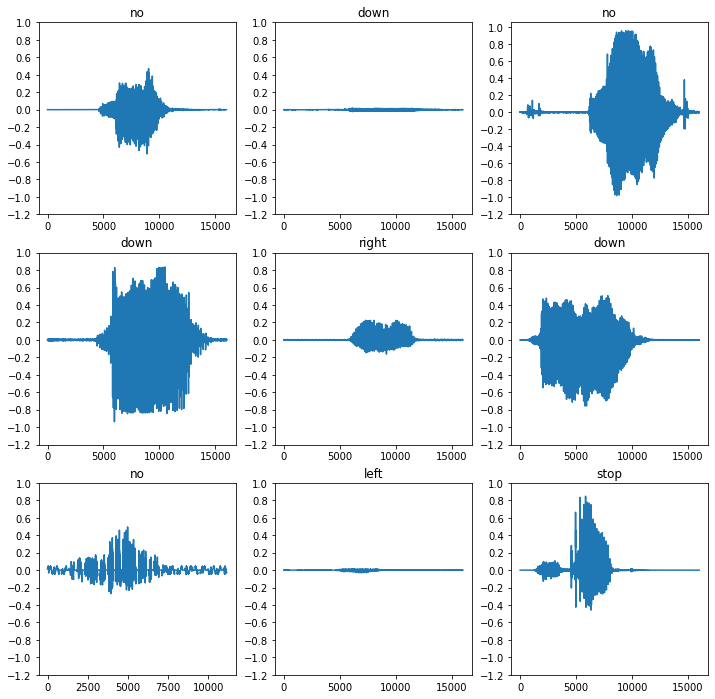

In [12]:
rows = 3 # Numero de filas
cols = 3 # Numero de columnas
n = rows * cols # Numero de elementos
fig, axes = plt.subplots(rows, cols, figsize=(12, 12)) # Creamos una figura con 3x3 subplots

for i, (auido, label) in enumerate(waveform_ds.take(n)): # Para cada audio y comando
    r = i // cols # Fila
    c = i % cols # Columna
    ax = axes[r][c] # Obtenemos el subplot
    ax.plot(auido.numpy()) # Graficamos el audio
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2)) # Establecemos los valores de los ejes y
    label = label.numpy().decode('utf-8') # Obtenemos el comando
    ax.set_title(label) # Establecemos el titulo

plt.show() # Mostramos la figura

### Convertir formas de onda en espectrogramas

Las formas de onda en el conjunto de datos se representan en el dominio del tiempo. A continuación, transformará las formas de onda de las señales de dominio de tiempo en señales de dominio de frecuencia de tiempo mediante el cálculo de la [transformada de Fourier de tiempo corto (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) para convertir las formas de onda en [espectrogramas](https://en.wikipedia.org/wiki/Spectrogram) , que muestran los cambios de frecuencia a lo largo del tiempo y pueden ser representados como imágenes 2D. Introducirá las imágenes del espectrograma en su red neuronal para entrenar el modelo.

Una transformada de Fourier ( [`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft) ) convierte una señal a las frecuencias de sus componentes, pero pierde toda la información de tiempo. En comparación, STFT ( [`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft) ) divide la señal en ventanas de tiempo y ejecuta una transformada de Fourier en cada ventana, preservando parte de la información de tiempo y devolviendo un tensor 2D en el que puede ejecutar convoluciones estándar.

Cree una función de utilidad para convertir formas de onda en espectrogramas:

- Las formas de onda deben tener la misma longitud, de modo que cuando las convierta en espectrogramas, los resultados tengan dimensiones similares. Esto se puede hacer simplemente rellenando con ceros los clips de audio que son más cortos que un segundo (usando [`tf.zeros`](https://www.tensorflow.org/api_docs/python/tf/zeros) ).

- Al llamar a [`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft) , elija los parámetros `frame_length` y `frame_step` modo que la "imagen" del espectrograma generado sea casi cuadrada. Para obtener más información sobre la elección de los parámetros STFT, consulte [este video de Coursera](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) sobre el procesamiento de señales de audio y STFT.

- La STFT produce una serie de números complejos que representan la magnitud y la fase. Sin embargo, en este tutorial solo usará la magnitud, que puede derivar aplicando [`tf.abs`](https://www.tensorflow.org/api_docs/python/tf/math/abs) en la salida de [`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft) .

In [13]:
def get_spectrogram(waveform):
    input_len = 16000 # Longitud de entrada
    waveform = waveform[:input_len] # Obtenemos el audio de entrada
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform), dtype=waveform.dtype) # Agregamos ceros a la izquierda
    
    waveform = tf.cast(waveform, dtype=tf.float32) # Convertimos el audio a float32
    equal_length = tf.concat([waveform, zero_padding], axis=0) # Agregamos ceros a la derecha
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128) # Obtenemos el espectrograma
    spectrogram = tf.abs(spectrogram) # Obtenemos la magnitud del espectrograma
    spectrogram = spectrogram[..., tf.newaxis] # Agregamos el eje de tamaño 1
    return spectrogram # Retornamos el espectrograma

A continuación, comience a explorar los datos. Imprima las formas de la forma de onda tensionada de un ejemplo y el espectrograma correspondiente, y reproduzca el audio original:

In [14]:
for waveform, label in waveform_ds.take(1): # Para cada audio y comando
    label = label.numpy().decode('utf-8') # Obtenemos el comando
    spectrogram = get_spectrogram(waveform) # Obtenemos el espectrograma

print('Label:', label) # Mostramos el comando
print('Waveform shape:', waveform.shape) # Mostramos el tamaño del audio
print('Spectrogram shape:', spectrogram.shape) # Mostramos el tamaño del espectrograma
print('Audio playback:') # Mostramos el audio de reproduccion
display(Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback:


Ahora, defina una función para mostrar un espectrograma:

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Trace la forma de onda del ejemplo a lo largo del tiempo y el espectrograma correspondiente (frecuencias a lo largo del tiempo):

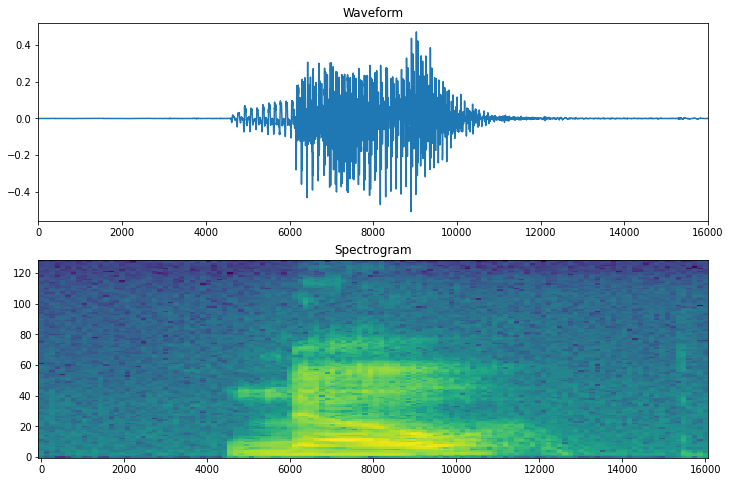

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8)) # Creamos una figura con 2 subplots
timescale = np.arange(waveform.shape[0]) # Obtenemos los valores de tiempo
axes[0].plot(timescale, waveform.numpy()) # Graficamos el audio
axes[0].set_title('Waveform') # Establecemos el titulo
axes[0].set_xlim([0, 16000]) # Establecemos el limite de X

plot_spectrogram(spectrogram, axes[1]) # Graficamos el espectrograma
axes[1].set_title('Spectrogram') # Establecemos el titulo
plt.show() # Mostramos la figura

Ahora, defina una función que transforme el conjunto de datos de forma de onda en espectrogramas y sus etiquetas correspondientes como ID de números enteros:

In [17]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio) # Obtenemos el espectrograma
    label_id = tf.argmax(label == commands) # Obtenemos el indice del comando
    return spectrogram, label_id # Retornamos el espectrograma y el indice del comando

Asigne `get_spectrogram_and_label_id` a través de los elementos del conjunto de datos con [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) :

In [18]:
spectrogram_ds = waveform_ds.map(
    map_func=get_spectrogram_and_label_id,
    num_parallel_calls=AUTOTUNE) # Creamos un dataset con los espectrogramas y los indices de los comandos

Examine los espectrogramas para ver diferentes ejemplos del conjunto de datos:

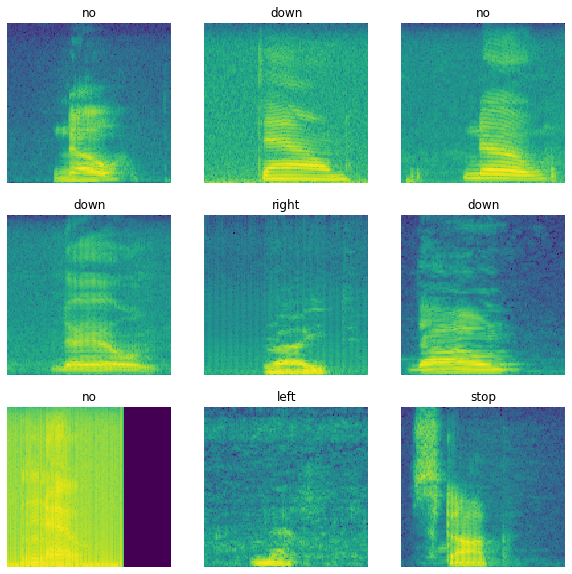

In [19]:
rows = 3 # Numero de filas
cols = 3 # Numero de columnas
n = rows*cols # Numero de elementos
fig, axes = plt.subplots(rows, cols, figsize=(10, 10)) # Creamos una figura con 3x3 subplots para mostrar los espectrogramas

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)): # Para cada espectrograma y indice de comando
  r = i // cols # Fila
  c = i % cols # Columna
  ax = axes[r][c] # Obtenemos el subplot
  plot_spectrogram(spectrogram.numpy(), ax) # Graficamos el espectrograma
  ax.set_title(commands[label_id.numpy()]) # Establecemos el comando
  ax.axis('off') # Ocultamos los ejes

plt.show()

### Construir y entrenar el modelo.
Repita el preprocesamiento del conjunto de entrenamiento en los conjuntos de validación y prueba:

In [20]:
def preprocess_dataset(files): # Funcion para preprocesar los datos
  files_ds = tf.data.Dataset.from_tensor_slices(files) # Creamos un dataset con los archivos

  output_ds = files_ds.map( # Aplicamos la funcion get_spectrogram_and_label_id
      map_func=get_waveform_and_label, # A la funcion get_waveform_and_label
      num_parallel_calls=AUTOTUNE) # Aplicamos el autotune

  output_ds = output_ds.map( # Aplicamos la funcion get_spectrogram_and_label_id
      map_func=get_spectrogram_and_label_id, # A la funcion get_spectrogram_and_label_id
      num_parallel_calls=AUTOTUNE) # Aplicamos el autotune
      
  return output_ds

In [21]:
train_ds = spectrogram_ds # Creamos el dataset de entrenamiento
val_ds = preprocess_dataset(val_files) # Creamos el dataset de validacion
test_ds = preprocess_dataset(test_files) # Creamos el dataset de prueba

Agrupe los conjuntos de entrenamiento y validación para el entrenamiento del modelo:

In [22]:
batch_size = 64 # Tamaño del batch
train_ds = train_ds.batch(batch_size) # Aplicamos el batch
val_ds = val_ds.batch(batch_size) # Aplicamos el batch

Agregue las operaciones [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) y [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) para reducir la latencia de lectura mientras entrena el modelo:

In [23]:
train_ds = train_ds.cache().prefetch(AUTOTUNE) # Cacheamos el dataset
val_ds = val_ds.cache().prefetch(AUTOTUNE) # Cacheamos el dataset 

Para el modelo, utilizará una **red neuronal convolucional (CNN)** simple, ya que ha transformado los archivos de audio en imágenes de espectrograma.

Su modelo [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) utilizará las siguientes capas de preprocesamiento de Keras:

- [`tf.keras.layers.Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing) : para reducir la muestra de la entrada y permitir que el modelo se entrene más rápido.
- [`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) : para normalizar cada píxel de la imagen en función de su media y desviación estándar.

Para la capa de `Normalization` , primero se necesitaría llamar a su método de adapt en los datos de entrenamiento para calcular las estadísticas agregadas (es decir, la media y la desviación estándar).

In [24]:
for spectrogram, _ in spectrogram_ds.take(1): # Para cada espectrograma
    input_shape = spectrogram.shape # Obtenemos el tamaño del espectrograma

print('Input shape:', input_shape) # Mostramos el tamaño del espectrograma
num_labels = len(commands) # Obtenemos el numero de comandos

norm_layer = tf.keras.layers.Normalization() # Creamos una capa de normalizacion
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec)) # Adaptamos la capa de normalizacion con los espectrogramas

model = tf.keras.Sequential([ # Creamos un modelo Sequential
    tf.keras.layers.InputLayer(input_shape=input_shape), # Añadimos la capa de entrada
    tf.keras.layers.Resizing(32, 32), # Añadimos la capa de redimensionamiento a 32x32
    norm_layer, # Añadimos la capa de normalizacion
    tf.keras.layers.Conv2D(32, 3, activation='relu'), # Añadimos la capa de convolucion con 32 filtros y kernel 3x3
    tf.keras.layers.Conv2D(64, 3, activation='relu'), # Añadimos la capa de convolucion con 64 filtros y kernel 3x3
    tf.keras.layers.MaxPooling2D(), # Añadimos la capa de MaxPooling
    tf.keras.layers.Dropout(0.25), # Añadimos la capa de Dropout con una probabilidad de 25% de ocultar una neurona
    tf.keras.layers.Flatten(), # Añadimos la capa de Flatten para convertir la matriz a un vector
    tf.keras.layers.Dense(128, activation='relu'), # Añadimos la capa de Dense con 128 neuronas y activacion ReLU
    tf.keras.layers.Dropout(0.5), # Añadimos la capa de Dropout con una probabilidad de 50% de ocultar una neurona
    tf.keras.layers.Dense(num_labels) # Añadimos la capa de Dense con num_labels 
])

model.summary() # Mostramos el modelo

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

Configure el modelo de Keras con el optimizador de Adam y la pérdida de entropía cruzada:

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), # Optimizador Adam con un learning rate de 0.001
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Loss SparseCategoricalCrossentropy
    metrics=['accuracy'] # Metricas de precision y recall
)

In [26]:
EPOCHS = 10 # Numero de epocas
history = model.fit(
    train_ds, # Dataset de entrenamiento
    validation_data=val_ds, # Dataset de validacion
    epochs=EPOCHS, # Numero de epocas
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2) # Callbacks EarlyStopping con una esperanza de 2 epocas
)

Epoch 1/10
100/100 [==============================] - 31s 306ms/step - loss: 1.7158 - accuracy: 0.3762 - val_loss: 1.2992 - val_accuracy: 0.5600
Epoch 2/10
100/100 [==============================] - 29s 288ms/step - loss: 1.1602 - accuracy: 0.5950 - val_loss: 0.9460 - val_accuracy: 0.6888
Epoch 3/10
100/100 [==============================] - 23s 229ms/step - loss: 0.8963 - accuracy: 0.6855 - val_loss: 0.8220 - val_accuracy: 0.7300
Epoch 4/10
100/100 [==============================] - 24s 237ms/step - loss: 0.7458 - accuracy: 0.7333 - val_loss: 0.7333 - val_accuracy: 0.7613
Epoch 5/10
100/100 [==============================] - 22s 225ms/step - loss: 0.6416 - accuracy: 0.7766 - val_loss: 0.6895 - val_accuracy: 0.7887
Epoch 6/10
100/100 [==============================] - 22s 222ms/step - loss: 0.5733 - accuracy: 0.7944 - val_loss: 0.6610 - val_accuracy: 0.7987
Epoch 7/10
100/100 [==============================] - 23s 232ms/step - loss: 0.5027 - accuracy: 0.8231 - val_loss: 0.6164 - val_ac

Tracemos las curvas de pérdida de entrenamiento y validación para verificar cómo ha mejorado su modelo durante el entrenamiento:

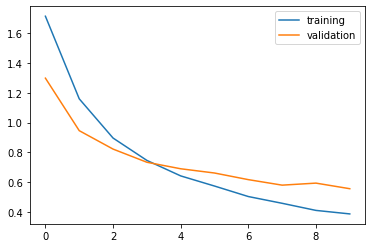

In [27]:
metrics = history.history # Obtenemos las metricas
plt.plot(history.epoch, metrics['loss'], metrics['val_loss']) # Graficamos las metricas
plt.legend(['training', 'validation']) # Mostramos las etiquetas
plt.show() # Mostramos el grafico

### Evaluar el rendimiento del modelo.
Ejecute el modelo en el conjunto de prueba y verifique el rendimiento del modelo:

In [28]:
test_audio = [] # Creamos una lista para almacenar los audios de prueba
test_labels = [] # Creamos una lista para almacenar los comandos de prueba

for auido, label in test_ds:
    test_audio.append(auido.numpy()) # Añadimos el audio a la lista
    test_labels.append(label.numpy()) # Añadimos el comando a la lista

test_audio = np.array(test_audio) # Convertimos la lista en un array
test_labels = np.array(test_labels) # Convertimos la lista en un array

In [29]:
y_pred = np.argmax(model.predict(test_audio), axis=1) # Predecimos los comandos
y_true = test_labels # Obtenemos los comandos reales

test_acc = sum(y_pred == y_true) / len(y_true) # Calculamos la precision
print(f'Test set accuracy: {test_acc:.0%}') # Mostramos la precision

Test set accuracy: 84%


### Ejecutar inferencia en un archivo de audio.
Finalmente, verifique la salida de predicción del modelo utilizando un archivo de audio de entrada de alguien que dice "no". ¿Qué tan bien funciona tu modelo?


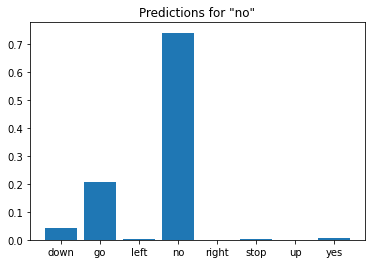

In [30]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav' # Archivo de ejemplo

sample_ds = preprocess_dataset([str(sample_file)]) # Preprocesamos el dataset

for spectrogram, label in sample_ds.batch(1): # Para cada espectrograma
  prediction = model(spectrogram) # Predecimos el comando
  plt.bar(commands, tf.nn.softmax(prediction[0])) # Mostramos la prediccion
  plt.title(f'Predictions for "{commands[label[0]]}"') # Mostramos el comando
  plt.show()

Como sugiere el resultado, su modelo debería haber reconocido el comando de audio como "no".



In [ ]:
# guardamos el modelo
model.save('model.h5')

In [31]:
display(Audio(str(sample_file))) # Mostramos el audio